In [2]:
# %%
# -*- coding: utf-8 -*-
"""
@author: Amin
"""

import sys
sys.path.insert(1, '../')

import models
import jax.numpy as jnp
import jax
import loader

import inference
import visualizations
import utils

from sklearn.covariance import EmpiricalCovariance
from sklearn.decomposition import PCA


%load_ext autoreload
%autoreload 2

/mnt/home/anejatbakhsh/anaconda3/envs/jaxenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_params = {
    # path to trained RNN
    'file': '/mnt/home/anejatbakhsh/Desktop/Projects/DSA/results/configs/SVN-RNN_01_0.00_64/states_io.npy',
    'props':{'train':.8,'test':.1,'validation':.1},
    'seeds':{'train':2,'test':0,'validation':3}
}

dataloader = loader.RNNData(data_params)
y,ts = dataloader.load_train_data()

y = y[:,::2]
ts = ts[:,1::2]

ts = jnp.stack((
    dataloader.data['vel_train'][:,1::2,0],
    dataloader.data['pos_train'][:,1::2,0]
),axis=-1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


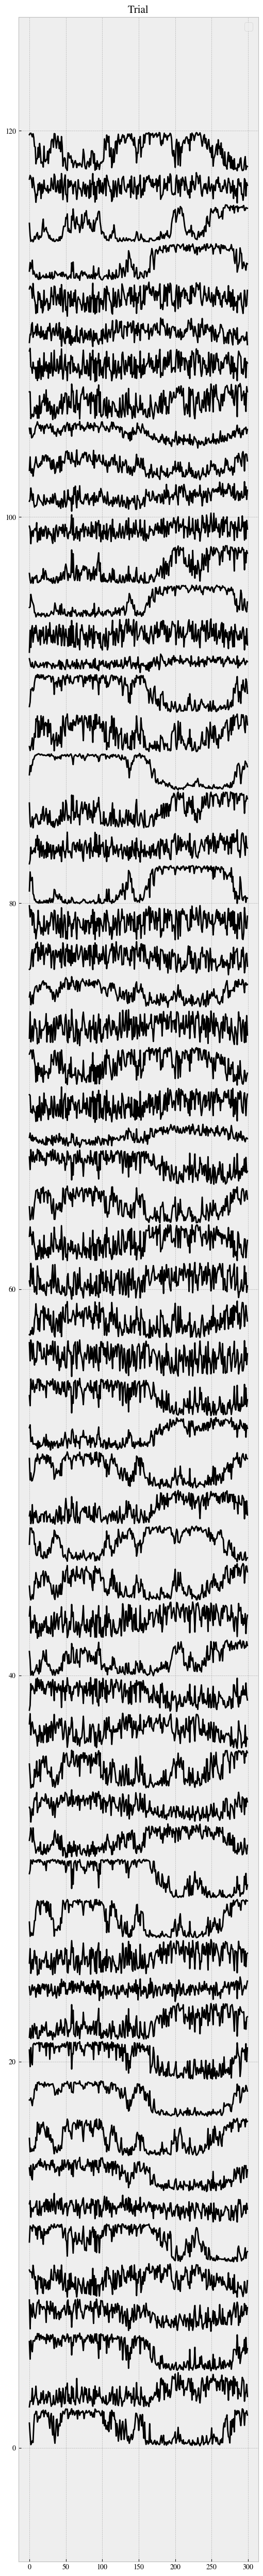

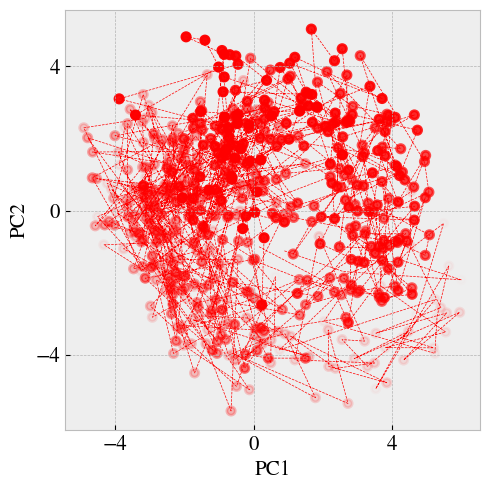

In [4]:
visualizations.plot_signals(
    [y[0]],
    titlestr='Trial'
)

visualizations.plot_states(
    [y[0],y[1]],
    ['y','y'],
    legend=False
)

In [5]:
B,T,N = y.shape

empirical_sigmas = jnp.array(
    [EmpiricalCovariance().fit(y[:,t]).covariance_ 
     for t in range(T)]
)

In [6]:
model_params={
    'D':3,
    'seed':5,
    'kernel_A': [
        {'type':'periodic','scale': 1e-1,'sigma': 1.,'normalizer': jnp.pi},
        {'type':'periodic','scale': 1e-1,'sigma': 1.,'normalizer': jnp.pi}
    ],
    'kernel_A_diag': 1e-1,
    'kernel_b': [
        {'type':'periodic','scale': 1e2,'sigma': 1.,'normalizer': jnp.pi},
        {'type':'periodic','scale': 1e2,'sigma': 1.,'normalizer': jnp.pi}
    ],
    'kernel_b_diag': 1e-1,
    'kernel_L': [
        {'type':'periodic','scale': 1e-1,'sigma': 1.,'normalizer': jnp.pi},
        {'type':'periodic','scale': 1e-1,'sigma': 1.,'normalizer': jnp.pi}
    ],
    'kernel_L_diag': 1e-1,
    'obs_noise':1e-1
}

optim_params = {
    'n_iter': 1000,
    'step_size': 1e-3,
    'gamma': 1
}

D = model_params['D']

In [7]:
seed = model_params['seed']
key = jax.random.PRNGKey(seed)

pca = PCA(n_components=D)
pca.fit(y.mean(0))
y_transformed = pca.transform(y.mean(0))

initial = models.InitialCondition(
    D,
    scale_tril=jnp.std(y[:,0])*jnp.eye(D),
)

lds = models.TimeVarLDS(
    D=D,initial=initial,
)


k1,key = jax.random.split(key,2)

emission = models.LinearEmission(
    key=k1,D=D,N=N,
    C=pca.components_.T,
    d=jnp.zeros(N)
)

kernel_A = utils.get_kernel(model_params['kernel_A'],model_params['kernel_A_diag'])
kernel_b = utils.get_kernel(model_params['kernel_b'],model_params['kernel_b_diag'])
kernel_L = utils.get_kernel(model_params['kernel_L'],model_params['kernel_L_diag'])

gps = {
    'A': models.GaussianProcess(kernel_A,D,D),
    'b': models.GaussianProcess(kernel_b,D,1),
    'L': models.GaussianProcess(kernel_L,D,D)
}

print(gps['A'].sample(key,ts[0])[...,0])
print(gps['A'].sample(key,ts[0])[...,-1])


likelihood = models.NormalConditionalLikelihood(
    N,
    scale_tril=model_params['obs_noise']*jnp.eye(N)
)
joint = models.GPLDS(
    gps,
    lds,
    emission,
    likelihood
)
k1,key = jax.random.split(key,2)


[[ 0.27352476 -0.74853176  0.43592453]
 [-0.05087423 -0.10645881 -0.631759  ]
 [ 0.00928878 -0.24495332  0.19580694]]
[[ 0.36155656  0.41131333 -0.22227944]
 [ 0.11882956 -0.337486    0.2858977 ]
 [ 0.07004434 -0.0564748  -0.13347194]]


In [8]:
C=15
coeffs = jnp.array([
    (a,b) for a in range(C) for b in range(C)
])*jnp.pi*2

basis_fn = \
    lambda ts: jnp.concatenate((
        jnp.sin(jnp.einsum('btk,ck->btc',ts,coeffs)),
        jnp.cos(jnp.einsum('btk,ck->btc',ts,coeffs))
    ),
axis=2)



recognition = inference.BasisZ(
    k1,
    D,
    T,
    basis_fn=basis_fn,
    basis_dim=coeffs.shape[0]*2,
    scale_A=1e1,
    scale_b=5e1,
    scale_L=1e-1
)

ELBO: 78417.26, Log Marginal: -78271.02, Log Prior: -146.25: 100%|██████████| 1000/1000 [03:28<00:00,  4.79it/s] 


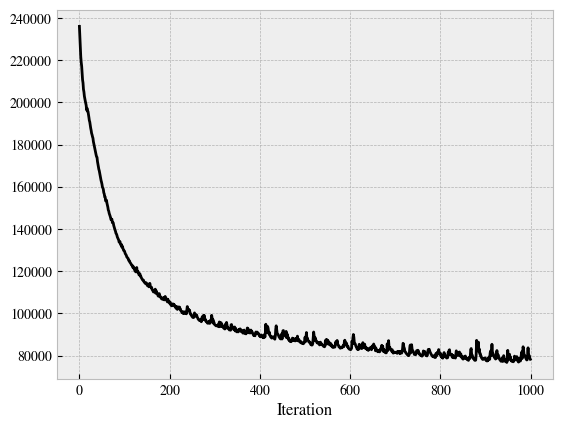

In [9]:
loss = inference.map(
    joint,
    recognition,
    y,
    ts,
    n_iter=1000,
    step_size=1e-4,
    gamma=optim_params['gamma']
)

visualizations.plot_loss(loss)

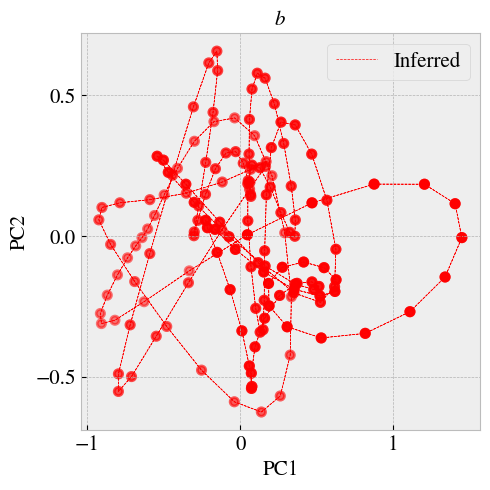

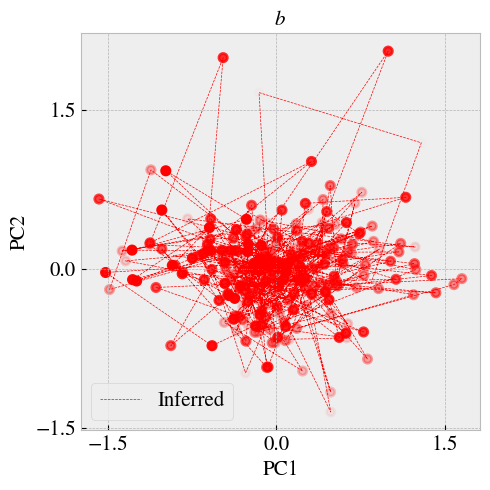

In [10]:
i = 0
grid_theta = jnp.stack((
    jnp.zeros(len(ts[i])),
    jnp.linspace(-1,1,len(ts[i]))
),axis=-1)


grid_EA,grid_Eb,grid_EL = recognition.posterior_mean(
    y[i],grid_theta,recognition.params
)

visualizations.plot_states(
    [grid_Eb],
    ['Inferred'],
    titlestr='$b$'
)


EA,Eb,EL = recognition.posterior_mean(
    y[i],ts[i],recognition.params
)

visualizations.plot_states(
    [Eb],
    ['Inferred'],
    titlestr='$b$'
)

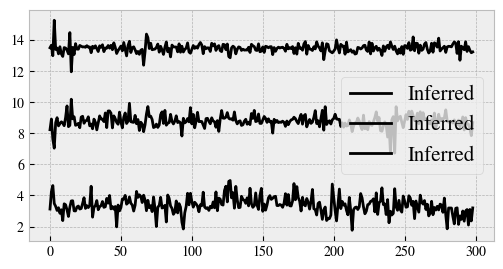

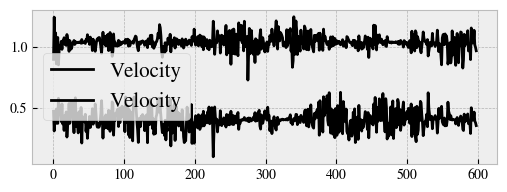

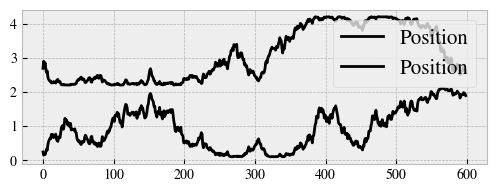

In [11]:
visualizations.plot_signals(
    [Eb,],
    labels=['Inferred'],
    margin=Eb.max()
)

visualizations.plot_signals(
    [dataloader.data['vel_train'][0]],
    labels=['Velocity'],
)

visualizations.plot_signals(
    [dataloader.data['pos_train'][0]],
    labels=['Position'],
)

In [12]:
mus,sigmas = lds.evolve_stats(EA,Eb,EL)

sigmas_obs = jnp.array([
    emission.C@sigmas[i]@emission.C.T + \
    likelihood.scale_tril@likelihood.scale_tril.T
    for i in range(len(sigmas))])
mus_obs = (emission.C @ mus.T).T 

empirical_sigmas = jnp.array(
    [EmpiricalCovariance().fit(y[:,t]).covariance_ 
     for t in range(T)]
)

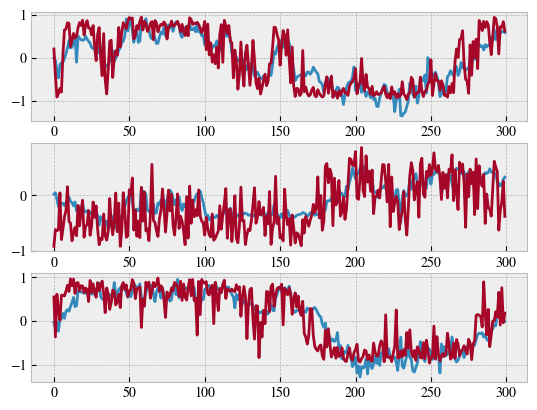

In [13]:
import matplotlib.pyplot as plt

for j in range(3):
    plt.subplot(3,1,j+1)
    plt.plot(mus_obs[:,j])
    plt.plot(y[i][:,j])
plt.show()

/mnt/home/anejatbakhsh/Desktop/Projects/GPLDS/codes/notebooks/../visualizations.py:176: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


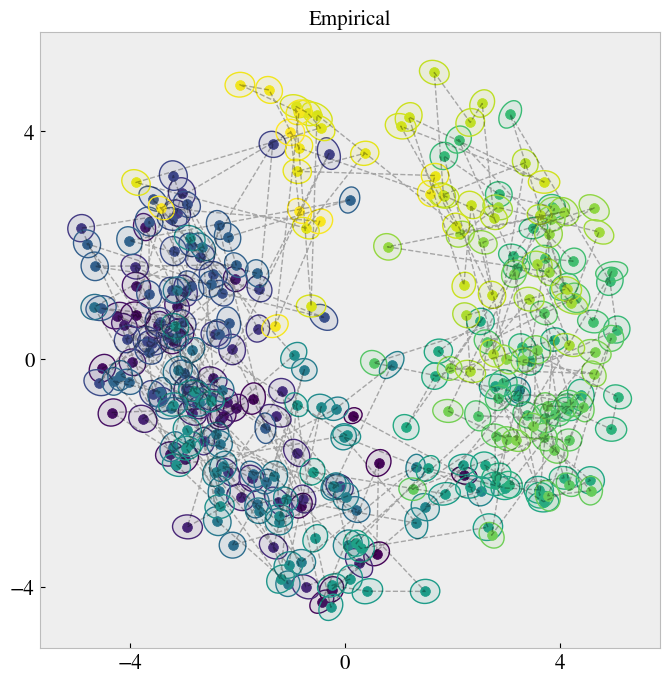

/mnt/home/anejatbakhsh/Desktop/Projects/GPLDS/codes/notebooks/../visualizations.py:176: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


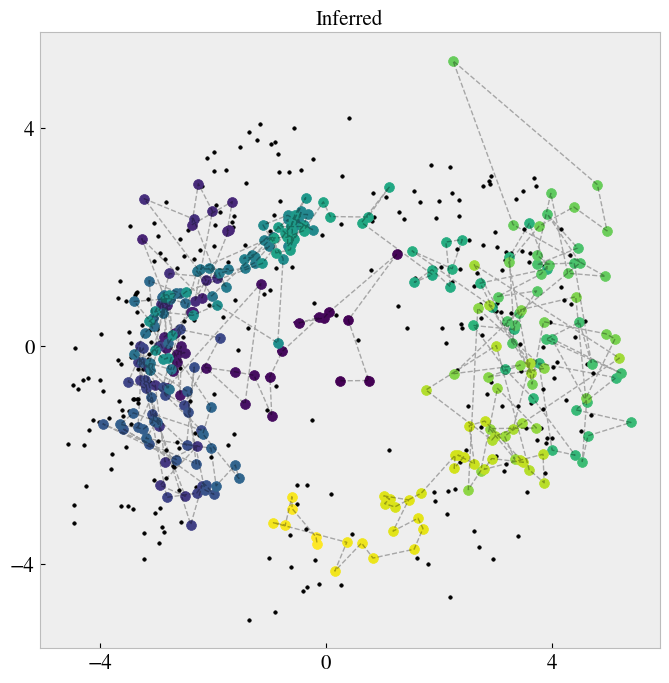

In [14]:
visualizations.visualize_pc(
    y[0][:,None],1e-3*empirical_sigmas,
    pc=y[0][None],
    linewidth=1,
    titlestr='Empirical'
)


visualizations.visualize_pc(
    mus_obs[:,None],1e-3*sigmas_obs,
    pc=y[i][None],
    linewidth=1,
    titlestr='Inferred'
)

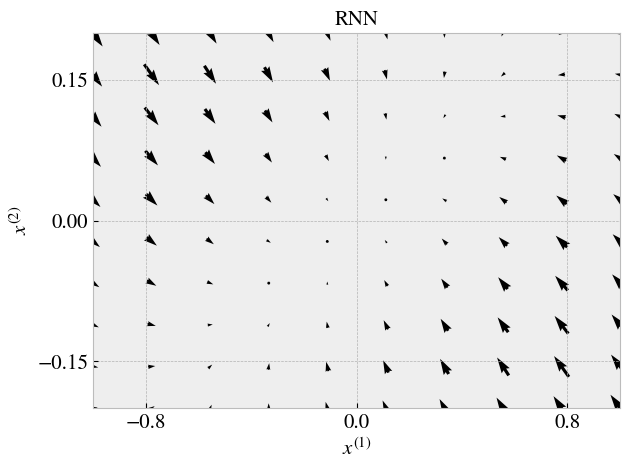

In [15]:
import os
visualizations.time_var_dynamics(
    grid_EA[:,:2,:2]-jnp.eye(2)[None],
    titlestr='RNN',
    save=False,
    scale=.4/grid_EA[:,:2,:2].max(),
    xlim=[-1,1],
    ylim=[-.2,.2],
    file='../results/A_rnn_'+ os.path.basename(os.path.dirname(data_params['file']))
)